In [13]:
#!pip install miceforest --no-cache-dir

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import make_scorer
import miceforest as mf
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='combo_lavSQ_MHC'
print(fileloc_data)
#sys.path.append('/'.join(os.getcwd().split('/')[0:4])+'/nan_smote/')
from FigPlotting import clusterPlot, plot_dendrogram
save_model_path_name='pickles/'
import pickle
cluster_model_fname="%sEDprofiling_Clusters.pkl"%(save_model_path_name)
if os.path.exists(cluster_model_fname):
    models_clustering = pickle.load(open(cluster_model_fname, "rb"))
    print('Loading final Clustering models complete')
else:
    models_clustering={}
from EDdataset_GGZ import colsTypeCast    
    #with open(cluster_model_fname, "wb") as file: 
    #    pickle.dump(models_clustering, file)
#############################################
#df_main.head(3)

/home/sreejita/anaconda3/envs/py_env1/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
Loading final Clustering models complete


In [2]:
df_all_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainDect_ED_SQ48_MHC_Honos_Lav.tsv', sep='\t', decimal=',')
print(df_all_combo['pid'].nunique(),df_all_combo['intid'].nunique())
pid_per_intid=df_all_combo['pid'].value_counts()
print('PIDs repeated in INTIDs: ', pid_per_intid[pid_per_intid.values>1])
df_all_combo[['EDtype', 'Split']].value_counts()

132 132
PIDs repeated in INTIDs:  Series([], Name: count, dtype: int64)


EDtype            Split
Anorexia nervosa  Train    35
Binge-ED          Train    20
Other ED          Train    17
Anorexia nervosa  Test     16
Bulimia nervosa   Train    13
Others            Train    12
Binge-ED          Test      8
Other ED          Test      5
Bulimia nervosa   Test      3
Others            Test      3
Name: count, dtype: int64

### Correlation Matrix of the combined datasets

In [3]:
df_Question_EDEQ=df_all_combo.copy()
df_Question_EDEQ['aantal_eerdere_trajecten'].loc[df_Question_EDEQ['aantal_eerdere_trajecten'].isnull()]=0
df_Question_EDEQ['duur_stoornis_in_jaren'].loc[df_Question_EDEQ['duur_stoornis_in_jaren'].isnull()]=0
df_edeq=pd.read_csv(fileloc_data+'maskedDAIsy_EDEQ_Score.tsv', sep='\t', decimal=',')
#print(df_edeq.columns)
df_edeq['intid'] = df_edeq['intid'].astype(float)
df_edeq_reqd=df_edeq[['intid', 'seq_num-edeq','EDEQ-eating', 'EDEQ-weight','EDEQ-bodyshape',
                      'EDEQ-lines']].loc[df_edeq['seq_num-edeq']==1].copy()
df_Question_EDEQ=pd.merge(df_edeq_reqd, df_Question_EDEQ, on='intid', how='inner')
df_Question_EDEQ, colsExtracted, subscales=colsTypeCast(df_Question_EDEQ)
#df_Question_EDEQ.columns
#subscales

In [4]:
#df_Question_EDEQ=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
cols2consider=['Main-Age','Main-Biosex','Main-Education'] +subscales['EDEQ']+subscales['DT']+\
                subscales['Lav']+subscales['SQ48']+subscales['MHCSF']
df_train_explore=df_Question_EDEQ[cols2consider].loc[df_Question_EDEQ['Split']=='Train']
df_test_explore=df_Question_EDEQ[cols2consider].loc[df_Question_EDEQ['Split']=='Test']
#print(df_train_explore['Main-Biosex'].value_counts())
#print(df_train_explore['EDtype'].value_counts())
#cols2consider=['Main-Age','Main-Biosex', 'Main-Education','ED_Codes','EDEQ-Score']+colsEDEQ+colsDectools+colsLAV+colsSQ48+colsMHCSF
#colRename_dict=dict(zip(cols2consider, colNames))
#df_all_combo.rename(columns=colRename_dict, inplace=True)
#ED_info=['intid','EDtype','EDEQscore', 'Split']
all_scores=['intid','EDEQ-Score',  'LAV-Score', 'SQ48-Score', 'MHCSF-Score', 'Split']
print(df_train_explore.dtypes)
#colRename_dict
#subscales

Main-Age                            int64
Main-Biosex                       float64
Main-Education                    float64
EDEQ-Score                        float64
EDEQ-eating                       float64
EDEQ-weight                       float64
EDEQ-bodyshape                    float64
DT-BMI                            float64
DT-IND_prev_spec_int_wo_eff       float64
DT-num_prev_routes                float64
DT-Disorder_Duration_Yrs          float64
DT-IND_depression_CMD             float64
DT-IND_BDL_CMD                    float64
DT-IND_OCD_CMD                    float64
DT-IND_others                     float64
Lav-Negative_appraisal_body       float64
Lav-Unfamiliarity_with_body       float64
Lav-Dissatisfaction_body          float64
Lav-Score                         float64
SQ48-Hostility                    float64
SQ48-Agoraphobia                  float64
SQ48-Anxiety                      float64
SQ48-Depression                   float64
SQ48-Cognitive_Complaints         

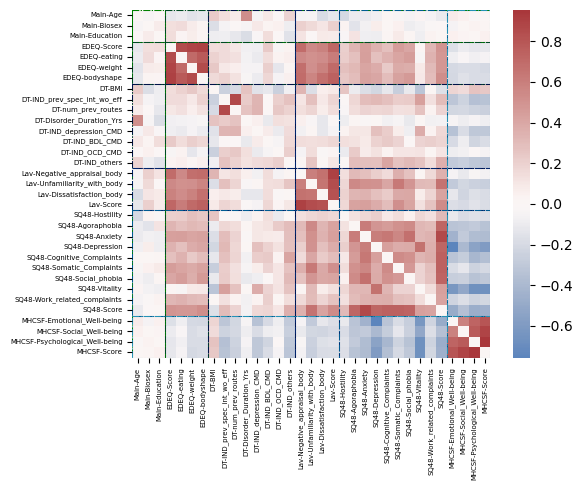

In [5]:
#df_dec_mhcsf_sq48
import matplotlib.patches as patches
#cols2consider=np.setdiff1d(cols2consider, ['EDtypes', 'bsex'])+['Edu_codes', 'ED_Codes']
cc_df_train_explore=df_train_explore[cols2consider].corr(method='spearman')
np.fill_diagonal(cc_df_train_explore.values, 0)
cc_col_dict=dict(zip(cc_df_train_explore.columns, cols2consider))
cc_df_train_explore.rename(columns=cc_col_dict, index=cc_col_dict, inplace=True)
fs=5
#print(df_train_explore['verstoord_eetpatroon'].value_counts())
fig0, ax0=plt.subplots(1,1,figsize=(6,5))
sns.axes_style('ticks')
#sns.set(font_scale=0.8)
sns.heatmap(cc_df_train_explore, cmap="vlag", annot=False, xticklabels=cols2consider, yticklabels=cols2consider, ax=ax0, 
            center=0)#ax0.set_xticks(range(0, 39, 1))
ax0.tick_params(axis='x', labelrotation=90)
ax0.tick_params(axis='y', labelrotation=0)
ax0.tick_params(left=True, bottom=True)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize = fs, ha='center')
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize = fs, va='center')
colors = plt.cycler("color", plt.cm.ocean(np.linspace(0, 1, 7+1)))
xy=[[0,0],[3,0],[3+len(subscales['EDEQ']),0],[3+len(subscales['EDEQ'])+len(subscales['DT']),0],
                #[3+len(subscales['EDEQ'])+len(subscales['DT']),0],
    [3+len(subscales['EDEQ'])+len(subscales['DT'])+len(subscales['Lav']),0],
    [3+len(subscales['EDEQ'])+len(subscales['DT'])+len(subscales['Lav'])+len(subscales['SQ48']),0],
    [3+len(subscales['EDEQ'])+len(subscales['DT'])+len(subscales['Lav'])+len(subscales['SQ48'])+len(subscales['MHCSF']),0]]

yx=[[0,0],[0,3],[0,3+len(subscales['EDEQ'])],[0,3+len(subscales['EDEQ'])+len(subscales['DT'])],
    #[0,3+len(subscales['EDEQ'])+len(subscales['DT'])],
    [0,3+len(subscales['EDEQ'])+len(subscales['DT'])+len(subscales['Lav'])],
    [0,3+len(subscales['EDEQ'])+len(subscales['DT'])+len(subscales['Lav'])+len(subscales['SQ48'])],
    [0,3+len(subscales['EDEQ'])+len(subscales['DT'])+len(subscales['Lav'])+len(subscales['SQ48'])+len(subscales['MHCSF'])]]

width, height=[3, len(subscales['EDEQ']),len(subscales['DT']),len(subscales['Lav']),len(subscales['SQ48']),len(subscales['MHCSF'])], 44.75
for k, col in zip(range(0,6), colors):
    ax0.add_patch(patches.Rectangle(xy[k],width[k],height,edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
    ax0.add_patch(patches.Rectangle(yx[k],height,width[k],edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
plt.tight_layout()
plt.savefig('figs/PDFs/correlationMatrix_adapted.pdf')
plt.savefig('figs/PNGs/correlationMatrix_adapted.png')

In [6]:
n, unique_pairs = 25,[] # change this to the number of pairs you want to get
top_pairs = cc_df_train_explore.unstack().sort_values(ascending=False)[:n*2]
bottom_pairs = cc_df_train_explore.unstack().sort_values(ascending=True)[:n*2]
# Create a list to store the top pairs without duplicates
# Iterate over the top pairs and add only unique pairs to the list
for pair in top_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
top_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    top_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
unique_pairs, n=[],10
for pair in bottom_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
bottom_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    bottom_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
corr_high_lows=pd.concat([top_pairs_df, bottom_pairs_df])
# Print the top pairs as a dataframe
#display(corr_high_lows)

Correlation matrix suggests the following:
- SQ48 and MHC-SF seem to have interesting negative Spearman correlation coefficients: Discuss with Pia, Joyce, Mladena
- LAV seems to be quite highly correlated with EDEQ score: Discuss if this relation to understand why this is so
- 

### Visualizing Missing Values

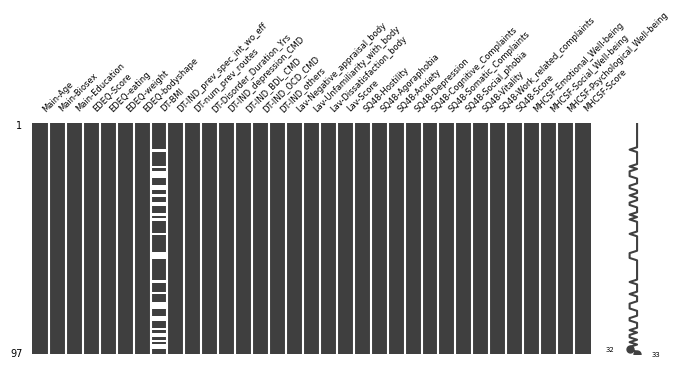

In [7]:
#!pip install missingno
import missingno as msno 
df_missing=df_train_explore[cols2consider].copy()
#df_missing.rename(columns=colRename_dict, inplace=True)
#df_all_combo.rename(columns=colRename_dict, inplace=True)
fig = msno.matrix(df_missing,figsize=(8, 3), fontsize=6)
grid_ax = fig.axes
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_NaNPatterns.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_NaNPatterns.png'%savetag)

In [9]:
df_train=df_Question_EDEQ[colsExtracted].loc[df_Question_EDEQ['Split']=='Train'].copy()
#df_train.rename(columns=colRename_dict, inplace=True)
df_test=df_Question_EDEQ[colsExtracted].loc[df_Question_EDEQ['Split']=='Test'].copy()
#df_test.rename(columns=colRename_dict, inplace=True)
cols_renamed=list(df_train.columns)
substrings=['Age', 'Education','Biosex', 'SQ48', 'MHCSF','Lav','DT']
cols2train_renamed={}
for sub in substrings:
    res = [i for i in cols_renamed if sub in i]
    cols2train_renamed[sub]=res
cols2train=cols2train_renamed['Age']+cols2train_renamed['Education']+cols2train_renamed['Biosex'] +cols2train_renamed['DT']+\
            cols2train_renamed['Lav']+cols2train_renamed['SQ48']+cols2train_renamed['MHCSF']
#print(cols2train)
#print(df_train.dtypes)

In [10]:
nan_mean=np.nanmean(df_train[cols2train].to_numpy(), axis=0)
nan_std=np.nanstd(df_train[cols2train].to_numpy(), axis=0)
z_train_explore_nan=((df_train[cols2train].to_numpy()-nan_mean)/nan_std)
z_train_df=pd.DataFrame(data=z_train_explore_nan, columns=cols2train)

kernel_mean_match = mf.ImputationKernel(data=z_train_df,num_datasets=1,mean_match_candidates=5)
kernel_mean_match.mice(10)
z_train_explore=pd.DataFrame(data=kernel_mean_match.complete_data(), columns=cols2train)
z_test_df=pd.DataFrame(data=((df_test[cols2train].to_numpy()-nan_mean)/nan_std), columns=cols2train)
z_test_explore=kernel_mean_match.impute_new_data(z_test_df)

#### Eigenvalue decomposition to PCA
#### PPCA

##### EVD of data $X$: steps:
1. Center $X$: $X_c= X-\hat{X}$
2. Covariance of $X_c$: $C=X_c^{T}X_c$ (This also ensures )
3. Eigenvalue decomposition of Covariance of $X_c$: $eigVal, eigVec=eig(C) $

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics
from sklearn.decomposition import FactorAnalysis, PCA
import matplotlib as mpl
#cols2train=np.setdiff1d(cols2train,['EDEQscore','ED_Codes'])
labels_true=df_train['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
eig_val, eig_vec=np.linalg.eig(np.dot(z_train_explore.T, z_train_explore))
print('Shape of eig vec and val', np.shape(eig_val), np.shape(eig_vec))
explained_var=np.cumsum(eig_val/np.sum(eig_val))
sind_eig_val=np.argsort(-1*(explained_var))
ndim=3
evd_z_train_explore=np.dot(z_train_explore,eig_vec[sind_eig_val[:ndim]].T)
print('Shape of evd_z_train_explore', np.shape(evd_z_train_explore))

transformer = FactorAnalysis(n_components=len(cols2train)-1, random_state=0, rotation="varimax")
fa_z_train = transformer.fit_transform(z_train_explore)
m, noise = transformer.components_, transformer.noise_variance_
var_expl_fa, m2 = np.zeros(len(cols2train)-1,), np.sum(m**2,axis=1)
for idx in range(0,len(cols2train)-1):
    var_expl_fa[idx]=(100*m2[idx])/(np.sum(m2)+np.sum(noise))
print('Shape of FA transformed data:', np.shape(fa_z_train))
pca = PCA(svd_solver='full').fit(z_train_explore)
variance_explained, components=np.cumsum(pca.explained_variance_)*100/np.sum(pca.explained_variance_), pca.components_
print("No. of intrinsic dims according to PCA: ", pca.n_components_)


Shape of eig vec and val (29,) (29, 29)
Shape of evd_z_train_explore (97, 3)
Shape of FA transformed data: (97, 28)
No. of intrinsic dims according to PCA:  29


(29, 29) 29.0 0.0


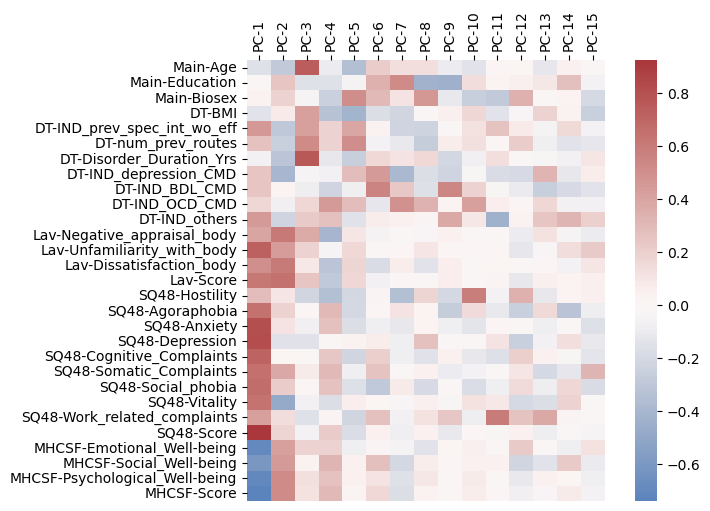

In [12]:
pca_loadings=pd.DataFrame(data=pca.components_.T * np.sqrt(pca.explained_variance_), 
                          index=z_test_df.columns, columns=['PC-'+str(x) for x in range(1,pca.n_components_+1)])
#pca_loadings.rename(index=df_train_explore.columns, inplace=True)
figPCA, axPCA=plt.subplots(1,1, figsize=(7,5), constrained_layout=True)
sns.heatmap(pca_loadings[['PC-'+str(x) for x in range(1,15+1)]], ax=axPCA, xticklabels=pca_loadings.columns[:16], 
            yticklabels=pca_loadings.index, cmap='vlag', center=0, annot=False)
pca_loadings.sort_values(by=['PC-1','PC-2','PC-3'], ascending=[False, False, False], key=abs, inplace=True)
#pca_loadings
ymin, ymax = axPCA.get_ylim()
print(pca_loadings.shape, ymin, ymax)
axPCA.tick_params(axis='x',top=True, bottom=False, labeltop=True, labelbottom=False)
axPCA.set_xticks(np.arange(15)+0.5, labels=pca_loadings.columns[:15], rotation=90)
axPCA.set_yticklabels(axPCA.get_yticklabels(), fontsize = fs-1, va='center', minor=True)
pca_loadings.head(3)
plt.savefig('figs/PDFs/ED_%s_PCA_loadings_adapted.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_PCA_loadings_adapted.png'%savetag, bbox_inches='tight', dpi=200)

In [13]:
pc_summary=pca_loadings[['PC-1','PC-2','PC-3']].T
col_summary=list(pc_summary.columns)
substrings=['SQ48', 'MHCSF','Lav','DT', 'Age', 'Education','Biosex']
subgroup_pc_loadings={}
for sub in substrings:
    res = [i for i in col_summary if sub in i]
    temp_mat=pc_summary[res].abs().to_numpy()
    subgroup_pc_loadings[sub]=np.mean(temp_mat)

subgroup_pc_loadings=pd.DataFrame.from_dict(subgroup_pc_loadings, orient='index', columns=['Mean_3_PCs'])
#pc_summary
subgroup_pc_loadings.sort_values(by='Mean_3_PCs', inplace=True)
subgroup_pc_loadings
#pc_summary[colsSQ48].median()

,Mean_3_PCs
Biosex,0.088225
Education,0.141153
DT,0.266613
SQ48,0.311207
Age,0.393792
MHCSF,0.428255
Lav,0.452093


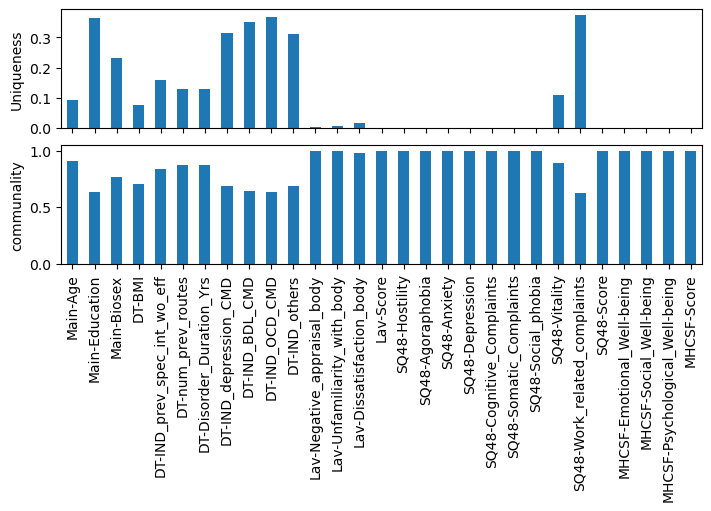

In [14]:
figFA1, axFA1=plt.subplots(2,1, figsize=(7,5), constrained_layout=True)

uniqueness = pd.Series(transformer.noise_variance_, index=z_train_df.columns)
uniqueness.plot(kind="bar",ylabel="Uniqueness", ax=axFA1[0])
axFA1[0].set_xticklabels('')
# Communality
communality = pd.Series(np.square(transformer.components_.T).sum(axis=1), index=z_train_df.columns)
communality.plot(kind="bar",ylabel="communality", ax=axFA1[1])

lambda_ = transformer.components_
psi = np.diag(uniqueness)
s = np.corrcoef(np.transpose(z_train_explore))
sigma = np.matmul(lambda_.T, lambda_) + psi
plt.savefig('figs/PDFs/ED_%s_FA_loadings_adapted.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_FA_loadings_adapted.png'%savetag, bbox_inches='tight', dpi=200)

(29, 29) 29.0 0.0


,Fac-1,Fac-2,Fac-3,Fac-4,Fac-5,Fac-6,Fac-7,Fac-8,Fac-9,Fac-10,...,Fac-20,Fac-21,Fac-22,Fac-23,Fac-24,Fac-25,Fac-26,Fac-27,Fac-28,Fac-29
Main-Age,1.000000,-0.044044,-0.046630,0.359121,0.119036,0.146614,0.788726,-0.031798,0.007772,-0.014453,...,-0.081491,-0.073672,-0.128354,0.014333,-0.117082,-0.166477,0.126649,-0.009113,0.023827,0.035022
DT-Disorder_Duration_Yrs,0.788726,-0.057571,-0.089699,0.302819,0.197238,0.225948,1.000000,0.043530,-0.075014,0.066596,...,-0.060612,-0.024298,-0.160695,0.049467,-0.072382,-0.115895,0.006449,-0.079179,-0.058387,-0.059054
DT-BMI,0.359121,-0.095327,-0.173449,0.785877,-0.088159,-0.059517,0.302819,-0.126198,-0.051816,-0.178541,...,-0.049315,-0.221431,-0.066053,-0.128921,-0.079999,-0.134567,0.138872,0.029249,0.144250,0.114788


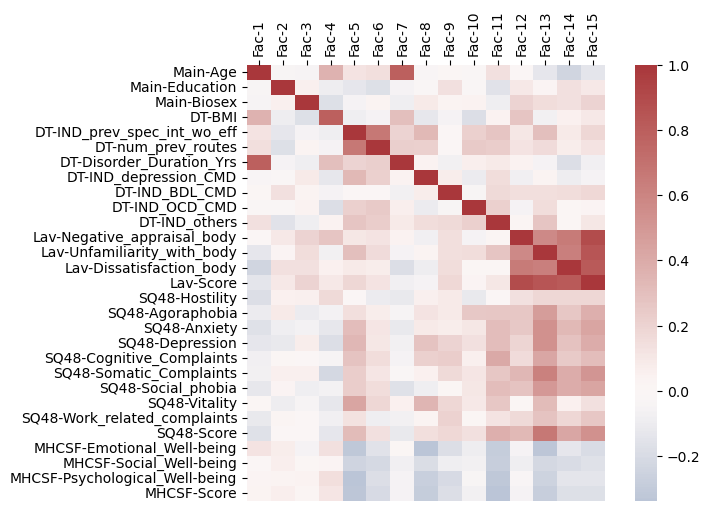

In [15]:
fa_loadings=pd.DataFrame(data=sigma,index=z_test_df.columns,
    columns=['Fac-'+str(x) for x in range(1,np.shape(sigma)[1]+1)])
#fa_loadings.rename(index=colRename_dict, inplace=True)
figFA, axFA=plt.subplots(1,1, figsize=(7,5), constrained_layout=True)
sns.heatmap(fa_loadings[['Fac-'+str(x) for x in range(1,15+1)]], ax=axFA, xticklabels=fa_loadings.columns[:16],
            yticklabels=fa_loadings.index, cmap='vlag', center=0)
fa_loadings.sort_values(by=['Fac-1','Fac-2','Fac-3'], ascending=[False, False, False], key=abs, inplace=True)
#pca_loadings
ymin, ymax = axFA.get_ylim()
print(fa_loadings.shape, ymin, ymax)
axFA.tick_params(axis='x',top=True, bottom=False, labeltop=True, labelbottom=False)
axFA.set_xticks(np.arange(15)+0.5, labels=fa_loadings.columns[:15], rotation=90)
axFA.set_yticklabels(axFA.get_yticklabels(), fontsize = fs-1, va='center', minor=True)
fa_loadings.head(3)

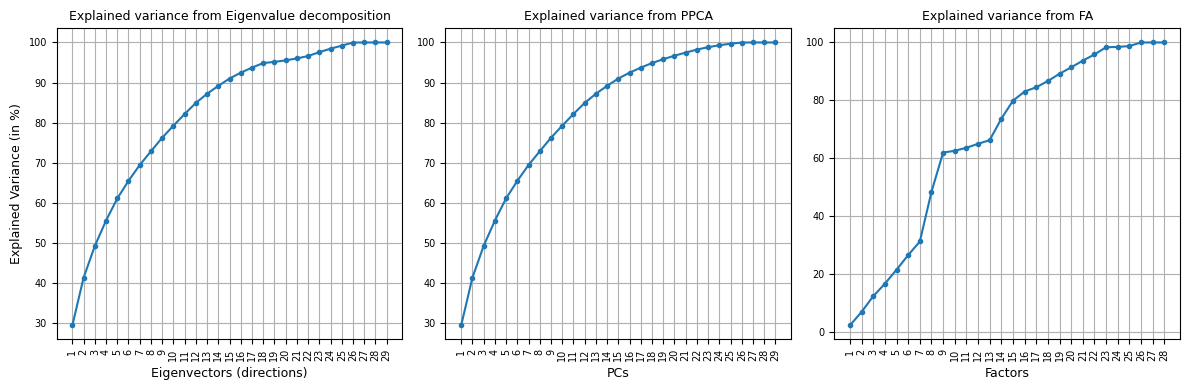

In [16]:
fs=9
f0,(a0, a1,a2)=plt.subplots(1,3,figsize=(12, 4))# Create a scree plot to visualize the explained variance
a0.plot(range(1, len(explained_var) + 1), # x-axis
         explained_var*100, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a0.set_title('Explained variance from Eigenvalue decomposition', fontsize=fs)
a0.set_xlabel('Eigenvectors (directions)', fontsize=fs)
a0.set_ylabel('Explained Variance (in %)', fontsize=fs)
#plt.xtick
# Add label to x-axis
a0.set_xticks(range(1, len(explained_var) + 1))
a0.set_xticklabels(a0.get_xticklabels(), fontsize=fs-2, rotation=90)
a0.set_yticklabels(a0.get_yticklabels(), fontsize=fs-2)
# Add grid in the background
a0.grid(True)
a1.plot(range(1, len(variance_explained) + 1), # x-axis
         variance_explained, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_xticks(range(1, len(variance_explained) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('')
a1.grid()
# Add title and axis label
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a2.plot(range(1, len(var_expl_fa) + 1), np.cumsum(var_expl_fa/sum(var_expl_fa))*100, # convert explained variance in percentage
         marker='o',markersize=3)
a2.set_xticks(range(1, len(var_expl_fa) + 1))
a2.set_xticklabels(a2.get_xticklabels(), fontsize=fs-2, rotation=90)
a2.set_yticklabels(a2.get_yticklabels(), fontsize=fs-2)
a2.set_title('Explained variance from FA', fontsize=fs)
a2.set_xlabel('Factors', fontsize=fs)
a2.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_PPCA_FA_adapted.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_EVD_PPCA_FA_adapted.png'%savetag, bbox_inches='tight', dpi=200)

#### Based on the above findings we will be proceeding with Main, EDtype, Lav, SQ48, and MHC_SF hereon

In [18]:
df_adapted_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainED_Lav_SQ48_MHCSF_Visit1.tsv', sep='\t', decimal=',')
df_adapted_combo, colsExtracted_adapted, subscales_adapted=colsTypeCast(df_adapted_combo)
adapted_combo_cols=['Main-Age','Lav-Dissatisfaction_body', 'Lav-Unfamiliarity_with_body','Lav-Negative_appraisal_body',
    'SQ48-Hostility','SQ48-Agoraphobia','SQ48-Anxiety','SQ48-Depression','SQ48-Cognitive_Complaints',
    'SQ48-Somatic_Complaints', 'SQ48-Social_phobia','SQ48-Vitality','SQ48-Work_related_complaints', 
    'MHCSF-Emotional_Well-being', 'MHCSF-Social_Well-being', 'MHCSF-Psychological_Well-being']
#print(df_adapted_combo['pid'].nunique(), df_adapted_combo['intid'].nunique())
print(df_adapted_combo[adapted_combo_cols].columns[df_adapted_combo[adapted_combo_cols].isnull().sum()>0])
df_train_adapted=df_adapted_combo[['intid', 'Split']+adapted_combo_cols].loc[df_adapted_combo['Split']=='Train']
df_test_adapted=df_adapted_combo[['intid', 'Split']+adapted_combo_cols].loc[df_adapted_combo['Split']=='Test']
print(len(adapted_combo_cols))

Index(['intid', 'Split', 'EDtype', 'Main-Age', 'Main-Biosex', 'Main-Education',
       'ED_Codes', 'EDEQ-Score', 'Lav-Negative_appraisal_body',
       'Lav-Unfamiliarity_with_body', 'Lav-Dissatisfaction_body', 'Lav-Score',
       'MHCSF-Emotional_Well-being', 'MHCSF-Social_Well-being',
       'MHCSF-Psychological_Well-being', 'MHCSF-Score', 'SQ48-Hostility',
       'SQ48-Agoraphobia', 'SQ48-Anxiety', 'SQ48-Depression',
       'SQ48-Cognitive_Complaints', 'SQ48-Somatic_Complaints',
       'SQ48-Social_phobia', 'SQ48-Vitality', 'SQ48-Work_related_complaints',
       'SQ48-Score'],
      dtype='object')
Index([], dtype='object')
16


Factor Analysis suggests 16 latent factors


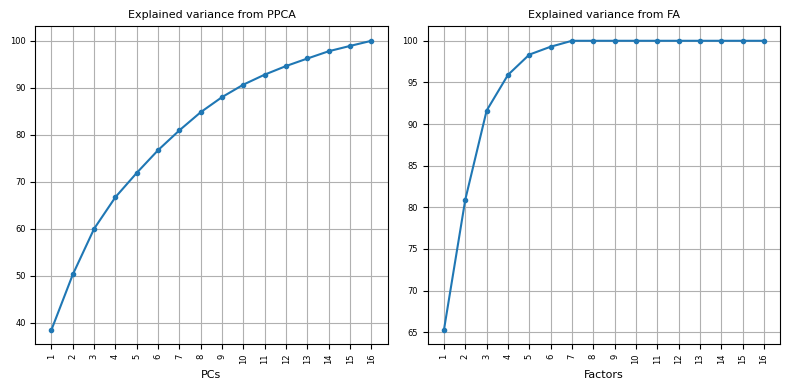

In [19]:
mean_adapted, std_adapted=df_train_adapted[adapted_combo_cols].mean(axis=0), df_train_adapted[adapted_combo_cols].std(axis=0)
z_adapted_train=(df_train_adapted[adapted_combo_cols]-mean_adapted)/std_adapted
z_adapted_test=(df_test_adapted[adapted_combo_cols]-mean_adapted)/std_adapted
pca_adapted = PCA(svd_solver='full').fit(z_adapted_train)
pca_z_train_adapted=pca_adapted.transform(z_adapted_train)
variance_explained_adapt=np.cumsum(pca_adapted.explained_variance_)*100/np.sum(pca_adapted.explained_variance_)
comp_adapt= pca_adapted.components_
fa_adapted = FactorAnalysis(n_components=len(adapted_combo_cols), random_state=0)
fa_z_train_adapted = fa_adapted.fit_transform(z_adapted_train)
m, noise = fa_adapted.components_, fa_adapted.noise_variance_
print('Factor Analysis suggests %d latent factors'%len(m))
#m1 = 
var_expl_fa, m2 = np.zeros(len(adapted_combo_cols),), np.sum(m**2,axis=1)
for idx in range(0,len(adapted_combo_cols)):
    var_expl_fa[idx]=(100*m2[idx])/(np.sum(m2)+np.sum(noise))

fs=8
fig,(a1,a2)=plt.subplots(1,2,figsize=(8, 4))# Create a scree plot to visualize the explained variance
a1.plot(range(1, len(variance_explained_adapt) + 1), # x-axis
         variance_explained_adapt, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_xticks(range(1, len(variance_explained_adapt) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('')
a1.grid()
# Add title and axis label
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a2.plot(range(1, len(var_expl_fa) + 1), np.cumsum(var_expl_fa/sum(var_expl_fa))*100,marker='o',markersize=3)
a2.set_xticks(range(1, len(var_expl_fa) + 1))
a2.set_xticklabels(a2.get_xticklabels(), fontsize=fs-2, rotation=90)
a2.set_yticklabels(a2.get_yticklabels(), fontsize=fs-2)
a2.set_title('Explained variance from FA', fontsize=fs)
a2.set_xlabel('Factors', fontsize=fs)
a2.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_PPCA_FA_adapted_reduced.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_PPCA_FA_adapted_reduced.png'%savetag, bbox_inches='tight', dpi=200)

#### The new cumulative sum of variance suggests that 
- *For PCA* n=11 PCs will explain more than 90% of the total variance of the dataset (PCA is based on EVD, hence hereon sticking to PCA)
- *For Factor Analysis* first n=7 explains 100% of the variance in the dataset

In [20]:
pca_ndim=11
data_to_cluster=pca_z_train_adapted[:,:pca_ndim]
pca_pdist_cos=pairwise_distances(data_to_cluster, metric='cosine')
pca_af = AffinityPropagation(affinity='precomputed',max_iter=200, convergence_iter=10,random_state=40,
                    ).fit(-1*pca_pdist_cos)
pca_cluster_centers_indices, pca_labels = pca_af.cluster_centers_indices_, pca_af.labels_
np.fill_diagonal(pca_pdist_cos, 0)
labels_true=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Train']
pca_n_clusters_ = len(pca_cluster_centers_indices)
print("Estimated number of clusters: %d" % pca_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, pca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, pca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, pca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, pca_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, pca_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pca_pdist_cos, pca_labels, metric="precomputed"))
z_df_train_explore=pd.DataFrame(z_adapted_train, columns=adapted_combo_cols)

Estimated number of clusters: 25
Homogeneity: 0.229
Completeness: 0.113
V-measure: 0.151
Adjusted Rand Index: 0.014
Adjusted Mutual Information: 0.052
Silhouette Coefficient: 0.165


In [21]:
fa_ndim=7
data_to_cluster=fa_z_train_adapted[:,:fa_ndim]
fa_pdist_cos=pairwise_distances(data_to_cluster, metric='cosine')
fa_af = AffinityPropagation(affinity='precomputed',max_iter=200, convergence_iter=10,random_state=42,
                    ).fit(-1*fa_pdist_cos)
fa_cluster_centers_indices, fa_labels = fa_af.cluster_centers_indices_, fa_af.labels_
np.fill_diagonal(fa_pdist_cos, 0)
labels_true=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Train']
fa_n_clusters_ = len(fa_cluster_centers_indices)
print("Estimated number of clusters: %d" % fa_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, fa_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, fa_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, fa_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, fa_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, fa_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(fa_pdist_cos, fa_labels, metric="precomputed"))
z_df_train_explore=pd.DataFrame(z_adapted_train, columns=adapted_combo_cols)

Estimated number of clusters: 21
Homogeneity: 0.185
Completeness: 0.096
V-measure: 0.127
Adjusted Rand Index: 0.014
Adjusted Mutual Information: 0.041
Silhouette Coefficient: 0.251


Estimated number of clusters: 9
Homogeneity: 0.067
Completeness: 0.049
V-measure: 0.057
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.017
Silhouette Coefficient: 0.079


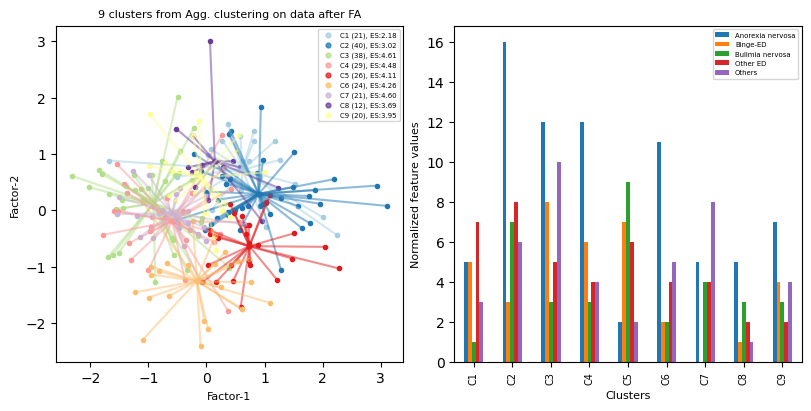

In [22]:
from sklearn.cluster import AgglomerativeClustering
save_model_path_name='pickles/'
random_seed = 15
random.seed(random_seed)
df_train_=df_adapted_combo[['intid']+adapted_combo_cols+['EDtype', 'EDEQ-Score']].loc[df_adapted_combo['Split']=='Train']
z_adapted_train['EDtype']=df_train_['EDtype']
z_adapted_train['EDEQ-Score']=df_train_['EDEQ-Score']
fa_ndim=8
data_to_cluster=pairwise_distances(fa_z_train_adapted[:,:fa_ndim], metric='cosine')
linkage, diss='complete', 'precomputed'
if os.path.exists(cluster_model_fname):
    cluster_model=models_clustering['Aggomerative_FA']
    agg_fa_clust, agg_fa_labels=cluster_model['model'], cluster_model['pred_labels']
    n_clusters_agg_fa=len(np.unique(agg_fa_labels))
    
else:    
    sill_coef=np.zeros((5,11))
    ncomp_opts=list(range(2,12))
    for idx,n_comp in enumerate(range(2,12)):
        for iter in range(0,5):
            try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity=diss, linkage=linkage).fit(data_to_cluster)
            sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric=diss)    
    if ncomp_opts[np.argsort(-1*np.mean(sill_coef,axis=0))[0]]>2:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[0]
    else:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[1]
    ncomp=ncomp_opts[idx]
    agg_fa_clust=AgglomerativeClustering(n_clusters=ncomp, affinity=diss, linkage=linkage).fit(data_to_cluster)
    agg_fa_labels=agg_fa_clust.fit_predict(data_to_cluster)
    n_clusters_agg_fa=len(np.unique(agg_fa_labels))
    print('Optimal number of clusters/ components based on silhoette coeff value=%d'%ncomp)
    cluster_model={'model': agg_fa_clust, 'name': 'Agglomerative', 'pred_labels': agg_fa_labels}
    models_clustering['Aggomerative_FA']=cluster_model
    

data_tabs={'data_to_cluster': data_to_cluster, 'data_to_plot': fa_z_train_adapted,
    'df': df_train_,'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['FA_Agg_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Agg. clustering on data after FA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}

print("Estimated number of clusters: %d" %n_clusters_agg_fa)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, agg_fa_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, agg_fa_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, agg_fa_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, agg_fa_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, agg_fa_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, agg_fa_labels, metric="precomputed"))

zs_fa_agg_ed_cluster_df, ed_fa_agg_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
df_cluster=df_train_[['intid', 'EDtype']].copy()


(9, 9)


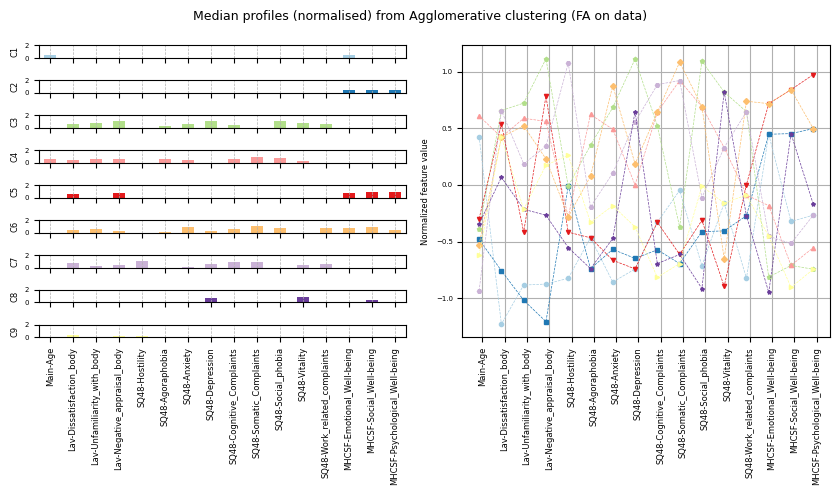

<Figure size 400x300 with 0 Axes>

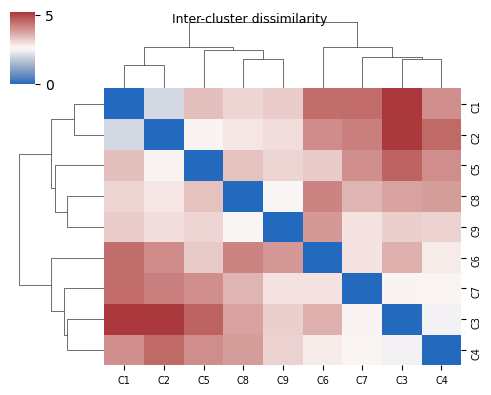

In [23]:
fig21=plt.figure(figsize=(8.5,5), constrained_layout=True)
marker_shapes=['o','s','p','^','v','D','H','*','>','<','P']
prof_colnames=adapted_combo_cols
df_cluster[fig_naming[0]]=np.nan
for nrow, col in zip(range(n_clusters_agg_fa), colors):
    ax21=plt.subplot(n_clusters_agg_fa,2,2*nrow+1)
    df_temp=zs_fa_agg_ed_cluster_df.iloc[nrow]
    df_cluster[fig_naming[0]].iloc[np.where(agg_fa_labels==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax21)
    ax21.set_ylim(0, 2)
    ax21.set_ylabel('C%d'%(nrow+1), fontsize=6)
    if nrow<n_clusters_agg_fa-1:        
        ax21.set_xticklabels('')
    else:
        ax21.set_xticklabels(prof_colnames, fontsize=6)  
    ax21.set_yticklabels(ax21.get_yticklabels(), fontsize=5)
    ax21.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax22=plt.subplot(1,2,2)
for nrow, col in zip(range(n_clusters_agg_fa), colors):
    df_temp=zs_fa_agg_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax22, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)

ax22.set_xticks(np.arange(len(adapted_combo_cols))+0.15, labels=adapted_combo_cols, rotation=90)
ax22.set_xticklabels(ax22.get_xticklabels(), fontsize=6, rotation=90)
ax22.set_yticklabels(ax22.get_yticklabels(), fontsize=5)
ax22.set_ylabel('Normalized feature value', fontsize=fs-2)
ax22.grid()

fig21.suptitle('Median profiles (normalised) from Agglomerative clustering (FA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_FA_AggC_Profiles.pdf'%savetag,bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_FA_AggC_Profiles.png'%savetag,bbox_inches='tight', dpi=200)

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
fig22= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_fa_agg_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig22=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig22.fig.suptitle('Inter-cluster dissimilarity\n', fontsize=9)
ticklabs=[]
for lab in fig22.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig22.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig22.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
#fig32.tight_layout()
fig22.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_AggC_FA.pdf'%savetag, bbox_inches='tight', dpi=200)
fig22.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_AggC_FA.png'%savetag, bbox_inches='tight', dpi=200)

Estimated number of clusters: 4
Homogeneity: 0.028
Completeness: 0.034
V-measure: 0.031
Adjusted Rand Index: 0.014
Adjusted Mutual Information: 0.012
Silhouette Coefficient: 0.176


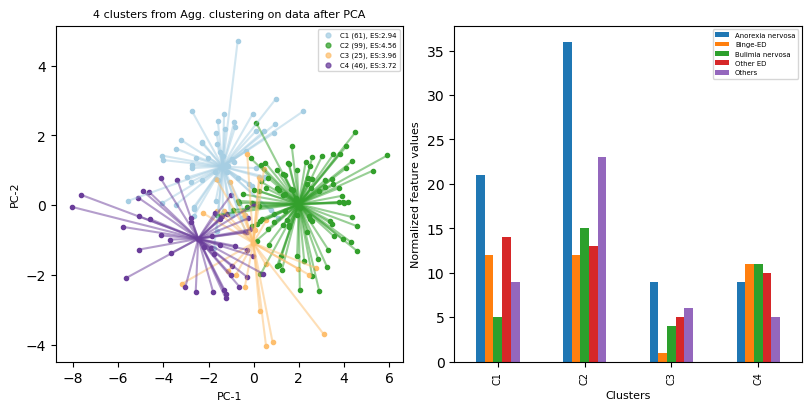

In [26]:
pca_ndim=12
random_seed = 101
np.random.seed(random_seed)
data_to_cluster=pairwise_distances(pca_z_train_adapted[:,:pca_ndim], metric='cosine')
linkage, diss='complete', 'precomputed'
df_train_=df_adapted_combo[['intid']+adapted_combo_cols+['EDtype', 'EDEQ-Score']].loc[df_adapted_combo['Split']=='Train']
data_tabs={'data_to_cluster': data_to_cluster, 'data_to_plot': pca_z_train_adapted,
    'df': df_train_,'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
sill_coef=np.zeros((5,11))
ncomp_opts=list(range(3,14))
if os.path.exists(cluster_model_fname):
    cluster_model=models_clustering['Aggomerative_PCA']
    agg_pca_clust, agg_pca_labels=cluster_model['model'], cluster_model['pred_labels']
    n_clusters_agg_pca=len(np.unique(agg_pca_labels))    
else:
    for idx,n_comp in enumerate(range(3,14)):
        for iter in range(0,5):
            try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity=diss, linkage=linkage).fit(data_to_cluster)
            sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric=diss)    
    if ncomp_opts[np.argsort(-1*np.mean(sill_coef,axis=0))[0]]>3:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[0]
    else:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[1]
    ncomp=ncomp_opts[idx]
    print('Optimal number of clusters/ components based on silhoette coeff value=%d'%ncomp)
    data_to_cluster=pairwise_distances(pca_z_train_adapted[:,:pca_ndim], metric='cosine')
    agg_pca_clust=AgglomerativeClustering(n_clusters=ncomp, affinity=diss, linkage=linkage).fit(data_to_cluster)
    agg_pca_labels=agg_pca_clust.fit_predict(data_to_cluster)
    n_clusters_agg_pca=len(np.unique(agg_pca_labels))
    cluster_model={'model': agg_pca_clust, 'name': 'Agglomerative', 'pred_labels': agg_pca_labels}
    
zs_pca_agg_ed_cluster_df, ed_pca_agg_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
z_adapted_train['EDtype']=df_train_['EDtype']
z_adapted_train['EDEQ-Score']=df_train_['EDEQ-Score']
models_clustering['Aggomerative_PCA']=cluster_model
    
print("Estimated number of clusters: %d" %n_clusters_agg_pca)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, agg_pca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, agg_pca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, agg_pca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, agg_pca_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, agg_pca_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, agg_pca_labels, metric="precomputed"))
#################################################################################
fig_naming=['PCA_Agg_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Agg. clustering on data after PCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}

(4, 4)


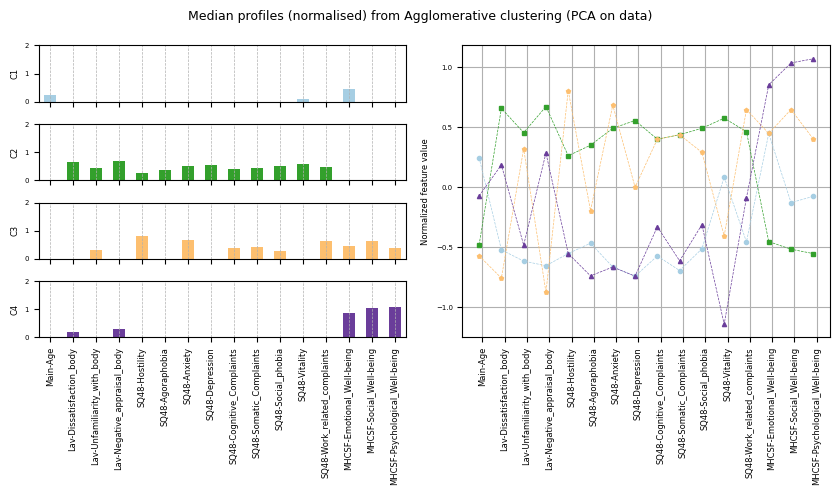

<Figure size 400x300 with 0 Axes>

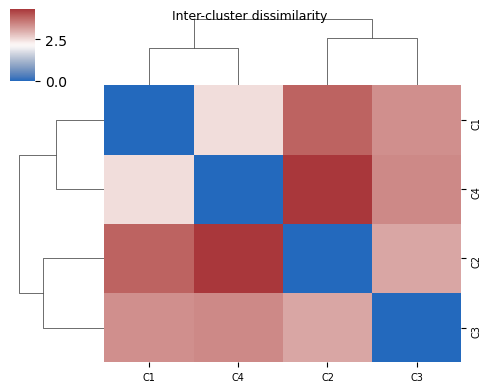

In [27]:
fig41=plt.figure(figsize=(8.5,5), constrained_layout=True)
marker_shapes=['o','s','p','^','v','D','H','*','>','<','P']
prof_colnames=adapted_combo_cols
df_cluster[fig_naming[0]]=np.nan
for nrow, col in zip(range(n_clusters_agg_pca), colors):
    ax41=plt.subplot(n_clusters_agg_pca,2,2*nrow+1)
    df_temp=zs_pca_agg_ed_cluster_df.iloc[nrow]
    df_cluster[fig_naming[0]].iloc[np.where(agg_pca_labels==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax41)
    ax41.set_ylim(0, 2)
    ax41.set_ylabel('C%d'%(nrow+1), fontsize=6)    
    if nrow<n_clusters_agg_pca-1:        
        ax41.set_xticklabels('')
    else:
        ax41.set_xticklabels(prof_colnames, fontsize=6)  
    ax41.set_yticklabels(ax41.get_yticklabels(), fontsize=5)
    ax41.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax42=plt.subplot(1,2,2)
for nrow, col in zip(range(n_clusters_agg_pca), colors):
    df_temp=zs_pca_agg_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax42, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)
ax42.set_xticks(np.arange(len(adapted_combo_cols))+0.15, labels=adapted_combo_cols, rotation=90)
ax42.set_xticklabels(ax42.get_xticklabels(), fontsize=6, rotation=90)
ax42.set_yticklabels(ax42.get_yticklabels(), fontsize=5)
ax42.set_ylabel('Normalized feature value', fontsize=fs-2)
ax42.grid()

fig41.suptitle('Median profiles (normalised) from Agglomerative clustering (PCA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_PCA_AggC_Profiles.pdf'%savetag,bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_PCA_AggC_Profiles.png'%savetag,bbox_inches='tight', dpi=200)

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
fig42= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_pca_agg_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig42=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')
fig42.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig42.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig42.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig42.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
fig42.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_AggC_PCA.pdf'%savetag, bbox_inches='tight', dpi=200)
fig42.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_AggC_PCA.png'%savetag, bbox_inches='tight', dpi=200)

#### Clustering with Gaussian Mixture models

In [28]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [77]:
param_grid = {"n_components": range(3, 15),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
ndim=10
grid_search = GridSearchCV(GaussianMixture(n_init=20, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(fa_z_train_adapted[:,:fa_ndim])
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
96,3,spherical,random_from_data,815.904733
72,3,spherical,kmeans,817.630677
84,3,spherical,k-means++,818.657369
97,4,spherical,random_from_data,847.149471
85,4,spherical,k-means++,847.750470


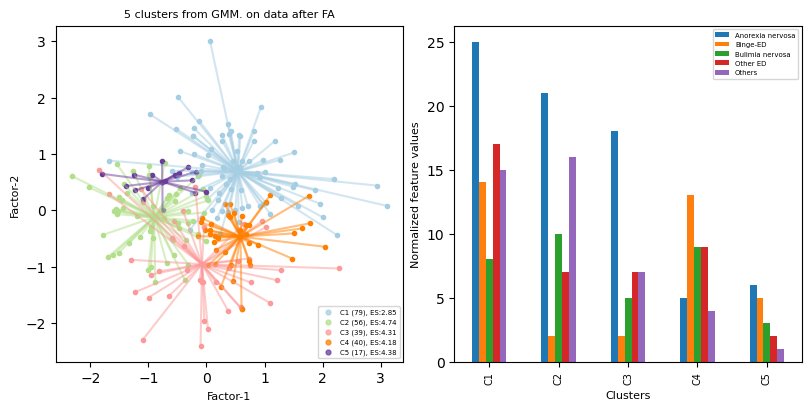

In [29]:
ndim=7
linkage, diss='complete', 'cosine'
data_to_cluster=fa_z_train_adapted[:,:ndim]
if os.path.exists(cluster_model_fname):
    cluster_model=models_clustering['GMM_FA']
    gmm_fa_model, gmm_fa_labels=cluster_model['model'], cluster_model['pred_labels']
    n_clusters_gmm_fa=len(np.unique(gmm_fa_labels))    
else:
    sill_coef=np.zeros((5,12))
    ncomp_opts=list(range(2,12))
    for idx,n_comp in enumerate(range(2,12)):
        for iter in range(0,5):
            fa_gmm_model_try=GaussianMixture(n_init=5, max_iter=300, n_components=n_comp, covariance_type='spherical',
                            init_params='kmeans').fit(fa_z_train_adapted[:,:ndim])
            sill_coef[iter, idx]=metrics.silhouette_score(fa_z_train_adapted[:,:ndim],
                                        fa_gmm_model_try.fit_predict(fa_z_train_adapted[:,:ndim]), metric=diss)
        print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))
    if ncomp_opts[np.argsort(-1*np.mean(sill_coef,axis=0))[0]]>3:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[0]
    else:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[1]
    ncomp=ncomp_opts[idx]
    print('Optimal number of clusters/ components based on silhoette coeff value=%d'%ncomp)
    n_clusters_gmm_fa, iters=ncomp,5
    gmm_fa_model=GaussianMixture(n_init=20, max_iter=100, n_components=n_clusters_gmm_fa, covariance_type='spherical', 
                          init_params='kmeans', random_state=101).fit(data_to_cluster)
    gmm_fa_labels=gmm_fa_model.predict(data_to_cluster)
    cluster_model={'model': gmm_fa_model, 'name': 'GMM', 'pred_labels': gmm_fa_labels}
    models_clustering['GMM_FA']=cluster_model
    print("Silhouette Coefficient: %0.3f"%(metrics.silhouette_score(data_to_cluster, gmm_fa_labels, metric="cosine")) )

data_tabs={'data_to_cluster':data_to_cluster, 'data_to_plot': fa_z_train_adapted,'df': df_train_,
          'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['FA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after FA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower right', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}
zs_fa_gmm_ed_cluster_df, ed_fa_gmm_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
#fa_gmm_ED_cluster=df_train_ #adapted_combo[['EDtype', 'EDEQscore']].loc[df_adapted_combo['Split']=='Train']
#fa_gmm_ED_cluster['GMMcluster']=fa_gmm_labels

#### Representative profiles of each cluster

(5, 5)


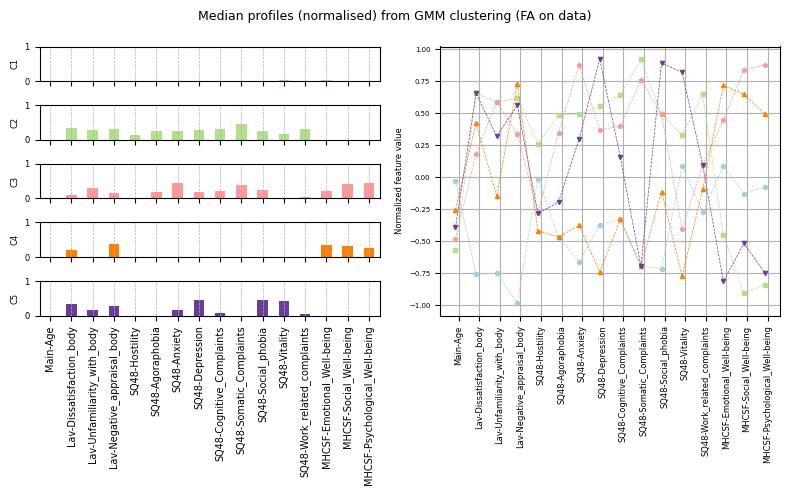

<Figure size 400x300 with 0 Axes>

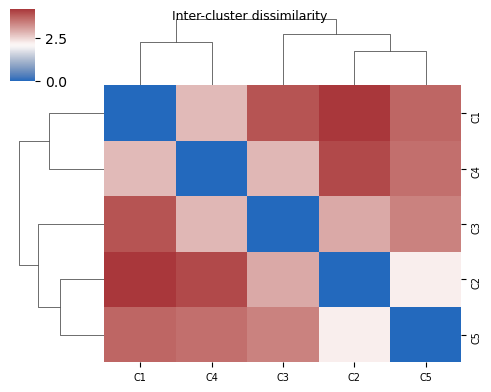

In [30]:
fig31=plt.figure(figsize=(8,5), constrained_layout=True)
marker_shapes=['o','s','p','^','v','D','H','*','>','<','P']
prof_colnames=adapted_combo_cols
df_cluster[fig_naming[0]]=np.nan
for nrow, col in zip(range(n_clusters_gmm_fa), colors):
    ax31=plt.subplot(n_clusters_gmm_fa,2,2*nrow+1)
    df_temp=zs_fa_gmm_ed_cluster_df.iloc[nrow]
    df_cluster[fig_naming[0]].iloc[np.where(gmm_fa_labels==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax31)
    ax31.set_ylim(0, 2)
    ax31.set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax31.set_yticklabels(ax31.get_yticklabels(), fontsize=6)
    if nrow<n_clusters_gmm_fa-1:        
        ax31.set_xticklabels('')
    else:
        ax31.set_xticklabels(prof_colnames, fontsize=7)    
    ax31.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax32=plt.subplot(1,2,2)
for nrow, col in zip(range(n_clusters_gmm_fa), colors):
    df_temp=zs_fa_gmm_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax32, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)

ax32.set_xticks(np.arange(len(adapted_combo_cols))+0.15, labels=adapted_combo_cols, rotation=90)
ax32.set_xticklabels(ax32.get_xticklabels(), fontsize=6, rotation=90)
ax32.set_yticklabels(ax32.get_yticklabels(), fontsize=5)
ax32.set_ylabel('Normalized feature value', fontsize=fs-2)
ax32.grid()

fig31.suptitle('Median profiles (normalised) from GMM clustering (FA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_FA_GMM_Profiles.pdf'%savetag,bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_FA_GMM_Profiles.png'%savetag,bbox_inches='tight', dpi=200)


fig32= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_fa_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig32=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig32.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig32.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig32.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig32.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
#fig32.tight_layout()
fig32.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_GMM_FA.pdf'%savetag, bbox_inches='tight', dpi=200)
fig32.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_GMM_FA.png'%savetag, bbox_inches='tight', dpi=200)

In [26]:
param_grid2 = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
ndim=11
grid_search2 = GridSearchCV(GaussianMixture(n_init=5, max_iter=300), param_grid=param_grid2, scoring=gmm_bic_score)
grid_search2.fit(pca_z_train_adapted[:,:ndim])
df2 = pd.DataFrame(grid_search2.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df2["mean_test_score"] = -df2["mean_test_score"]
df2 = df2.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df2.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
54,3,spherical,kmeans,1633.032308
72,3,spherical,random_from_data,1633.635765
63,3,spherical,k-means++,1633.698633
18,3,diag,random_from_data,1667.903188
55,4,spherical,kmeans,1669.785770


Silhouette Coefficient: 0.168


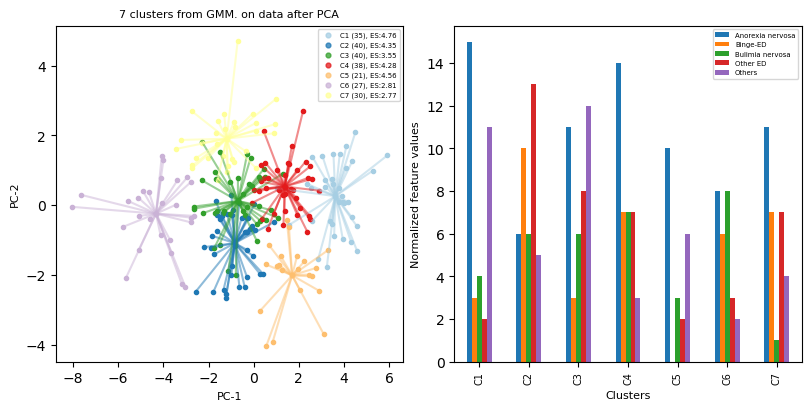

In [31]:
data_to_cluster=pca_z_train_adapted[:,:ndim]    
if os.path.exists(cluster_model_fname):
    cluster_model=models_clustering['GMM_PCA']
    gmm_pca_model, gmm_pca_labels=cluster_model['model'], cluster_model['pred_labels']
    n_clusters_gmm_pca=len(np.unique(gmm_pca_labels))    
else:
    sill_coef=np.zeros((5,11))
    random.seed(10)
    ndim=15
    linkage, diss='complete', 'cosine'
    ncomp_opts=list(range(3,14))
    
    for idx,n_comp in enumerate(range(3,14)):
        for iter in range(0,5):
            pca_gmm_model_try=GaussianMixture(n_init=5, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++').fit(pca_z_train_adapted[:,:ndim])
            sill_coef[iter, idx]=metrics.silhouette_score(pca_z_train_adapted[:,:ndim],
                                        pca_gmm_model_try.fit_predict(pca_z_train_adapted[:,:ndim]), metric=diss)
        print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))
    if ncomp_opts[np.argsort(-1*np.mean(sill_coef,axis=0))[0]]>3:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[0]
    else:
        idx=np.argsort(-1*np.mean(sill_coef,axis=0))[1]
    ncomp=ncomp_opts[idx]
    print('Optimal number of clusters/ components based on silhoette coeff value=%d'%ncomp)
    n_clusters_gmm_pca=ncomp
    gmm_pca_model=GaussianMixture(n_init=3, max_iter=200, n_components=n_clusters_gmm_pca, 
            covariance_type='spherical', init_params='kmeans', random_state=101).fit(data_to_cluster)
    cluster_model={'model': gmm_pca_model, 'name': 'GMM', 'pred_labels': gmm_pca_labels}
    models_clustering['GMM_PCA']=cluster_model
    pca_gmm_labels=pca_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, gmm_pca_labels, metric="cosine"))
pca_gmm_ED_cluster=df_train_.copy()#explore[['EDtype', 'EDEQscore']].copy()
pca_gmm_ED_cluster['GMMcluster']=gmm_pca_labels

data_tabs={'data_to_cluster':data_to_cluster, 'data_to_plot': pca_z_train_adapted[:,:ndim],'df': df_train_,
          'z_df': z_adapted_train, 'cols2train': adapted_combo_cols}
fig_naming=['PCA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after PCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_pca_gmm_ed_cluster_df, ed_pca_gmm_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

(7, 7)


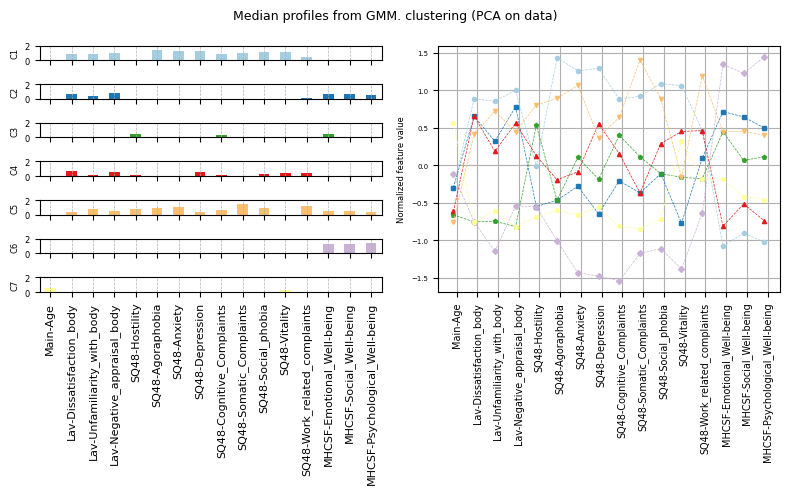

<Figure size 400x300 with 0 Axes>

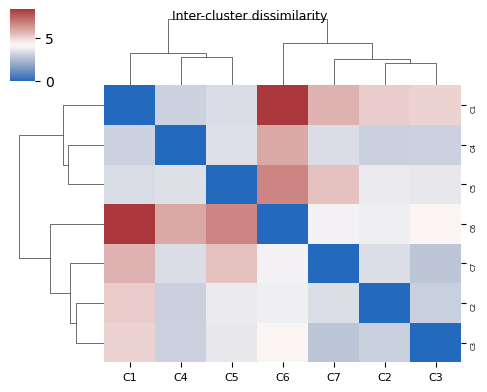

In [32]:
fig71 = plt.figure(figsize=(8,5), constrained_layout=True)
colnames=adapted_combo_cols#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
df_cluster[fig_naming[0]]=np.nan
for nrow, col in zip(range(n_clusters_gmm_pca), colors):
    ax71=plt.subplot(n_clusters_gmm_pca,2,2*nrow+1)
    df_temp=zs_pca_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_cluster[fig_naming[0]].iloc[np.where(gmm_pca_labels==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax71)
    ax71.set_ylim(0, 2)
    ax71.set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax71.set_yticklabels(ax71.get_yticklabels(), fontsize=6)
    if nrow<n_clusters_gmm_pca-1:        
        ax71.set_xticklabels('')
    else:
        ax71.set_xticklabels(colnames, fontsize=8)    
    ax71.grid(axis='x', linestyle = '--', linewidth = 0.5)

ax72=plt.subplot(1,2,2)
for nrow, col in zip(range(n_clusters_gmm_pca), colors):
    df_temp=zs_pca_gmm_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax72, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)

ax72.set_xticks(np.arange(len(adapted_combo_cols))+0.15, labels=adapted_combo_cols, rotation=90)
ax72.set_xticklabels(ax72.get_xticklabels(), fontsize=7, rotation=90)
ax72.set_yticklabels(ax72.get_yticklabels(), fontsize=5, rotation=0)
ax72.set_ylabel('Normalized feature value', fontsize=fs-2)
ax72.grid()
fig71.suptitle('Median profiles from GMM. clustering (PCA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_PCA_GMM_Profiles.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_PCA_GMM_Profiles.png'%savetag, bbox_inches='tight', dpi=200)

fig72= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_pca_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig72=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig72.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig72.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig72.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=8)
fig72.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=5)
fig72.savefig('figs/PDFs/ED_%s_Clustermap_Proximity_GMM_PCA.pdf'%savetag, bbox_inches='tight', dpi=200)
fig72.savefig('figs/PNGs/ED_%s_Clustermap_Proximity_GMM_PCA.png'%savetag, bbox_inches='tight', dpi=200)

In [33]:
if colsDectools[0] in df_Question_EDEQ.columns:
    print('Yes')
else:
    print('No')

NameError: name 'colsDectools' is not defined

In [34]:
df_cluster
df_Question_EDEQ.rename(columns=colRename_dict, inplace=True)
df_DT_deets=df_Question_EDEQ[['intid','DT-num_prev_routes']].loc[
        df_Question_EDEQ['intid'].astype(float).isin(df_cluster['intid'].astype(float))].copy()
#df_cluster.merge(df_DT_deets, on='intid', how='inner')
df_new_cluster=df_cluster.copy()
df_DT_deets=pd.merge(df_DT_deets, df_new_cluster, on='intid', how='inner')
df_DT_deets

,intid,DT-num_prev_routes,EDtype,FA_Agg_Clustering,PCA_Agg_Clustering,FA_GMM_Clustering,PCA_GMM_Clustering
0,1491.0,8.0,Binge-ED,C4,C1,C4,C2
1,1402.0,1.0,Anorexia nervosa,C2,C1,C1,C3
2,1294.0,5.0,Others,C3,C2,C5,C1
3,1449.0,2.0,Binge-ED,C9,C1,C1,C4
4,1560.0,2.0,Anorexia nervosa,C9,C1,C4,C2
...,...,...,...,...,...,...,...
92,1533.0,0.0,Anorexia nervosa,C6,C3,C3,C5
93,1707.0,2.0,Others,C3,C2,C2,C1
94,1371.0,0.0,Anorexia nervosa,C3,C2,C2,C1
95,1677.0,0.0,Anorexia nervosa,C2,C4,C1,C6


In [35]:
df_DT_deets.to_csv('tabs/'+'EDcombined_ClusterMembership_20241119.tsv', sep='\t',index=False)

